In [1]:
import pandas as pd
from prophet import Prophet
import seaborn as sns
from sklearn.model_selection import ParameterGrid
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("dataset_cuaca_perjam-prophet.csv")

In [3]:
df

,date,year,month,day,hour,t2m,rh2m,ps,ws10m
0,11/30/2013,2013.0,11.0,30.0,7:00:00,27.36,78.94,100.80,3.17
1,11/30/2013,2013.0,11.0,30.0,8:00:00,28.47,73.19,100.85,2.65
2,11/30/2013,2013.0,11.0,30.0,9:00:00,29.44,69.56,100.83,2.04
3,11/30/2013,2013.0,11.0,30.0,10:00:00,30.12,67.38,100.77,1.73
4,11/30/2013,2013.0,11.0,30.0,11:00:00,30.44,66.38,100.70,1.87
...,...,...,...,...,...,...,...,...,...
1048570,--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048571,--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048572,--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048573,--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## PREPROCESSING

In [4]:
df.dropna(inplace=True)

In [5]:
df = df.drop(columns=['year', 'month', 'day'], axis=1)

In [6]:
df.isnull().sum()

date     0
hour     0
t2m      0
rh2m     0
ps       0
ws10m    0
dtype: int64

In [7]:
df.dtypes

date      object
hour      object
t2m      float64
rh2m     float64
ps       float64
ws10m    float64
dtype: object

In [8]:
df['date'] = pd.to_datetime(df['date'])
df['hour'] = pd.to_timedelta(df['hour'])
df['time'] = df['date'] + df['hour']

In [9]:
del df['date']
del df['hour']

In [10]:
df.rename(
    columns={"time": "ds", "rh2m": "y"},
    inplace=True,
)

In [11]:
df.dtypes

t2m             float64
y               float64
ps              float64
ws10m           float64
ds       datetime64[ns]
dtype: object

In [12]:
df.set_index(df['ds'], inplace = True)

In [13]:
# df['T_target'] = df.shift(-1)['T2M']
# df['RH_target'] = df.shift(-1)['RH2M']
# df['PS_target'] = df.shift(-1)['PS']
# df['WS_target'] = df.shift(-1)['WS10M']

In [14]:
df.dropna(inplace=True)

In [15]:
# # df.sort_index(inplace=True)

# # start_date = '2021-04-01 09:00:00'
# # end_date = '2022-05-01 16:00:00'

# df = df.iloc[-100:]

In [16]:
# del df['ds']
# del df['rh2m']
# del df['ps']
# del df['ws10m']

In [17]:
# # Concatenate all variables into one DataFrame
# df = pd.DataFrame()
# df_prophet['ds'] = df['ds']
# df_prophet['y'] = df['y']
# df_prophet['humidity'] = df['rh2m']
# df_prophet['wind_speed'] = df['ws10m']
# df_prophet['pressure'] = df['ps']

In [18]:
import numpy as np 

Q1 = np.percentile(df['y'], 25)
Q3 = np.percentile(df['y'], 75)

IQR = Q3 - Q1

lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

outliers = (df['y'] < lower_fence) | (df['y'] > upper_fence)
num_outliers = sum(outliers)

print("Jumlah outlier:", num_outliers)



Jumlah outlier: 1583


In [19]:
# import seaborn as sns
# def replace_interpolate(df, column):
#     sns.boxplot(df[column])
#     plt.title(f'Original Box Plot of {column}')
#     plt.show()

#     # Calculate Q1 (25th percentile) and Q3 (75th percentile)
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)

#     # Calculate the Interquartile Range (IQR)
#     IQR = Q3 - Q1

#     # Define the lower and upper fences
#     lower_fence = Q1 - 1.5 * IQR
#     upper_fence = Q3 + 1.5 * IQR

#     # Identify outliers
#     outliers = (df[column] < lower_fence) | (df[column] > upper_fence)

#     # Replace outliers with NaN
#     df[column][outliers] = np.nan

#     # Interpolate the NaN values
#     df[column] = df[column].interpolate()

#     sns.boxplot(df[column])
#     plt.title(f'Box Plot after Replacing Outliers of {column}')
#     plt.show()

#     return df

# # Sample usage
# # Assuming 'df' is your DataFrame and 'T2M' is the column name you want to process
# df = replace_interpolate(df, 'y')

In [20]:
df = df.sort_index()

train_percentage = 0.8
train_size = int(len(df) * train_percentage)

train_data = df[:train_size]
test_data = df[train_size:]

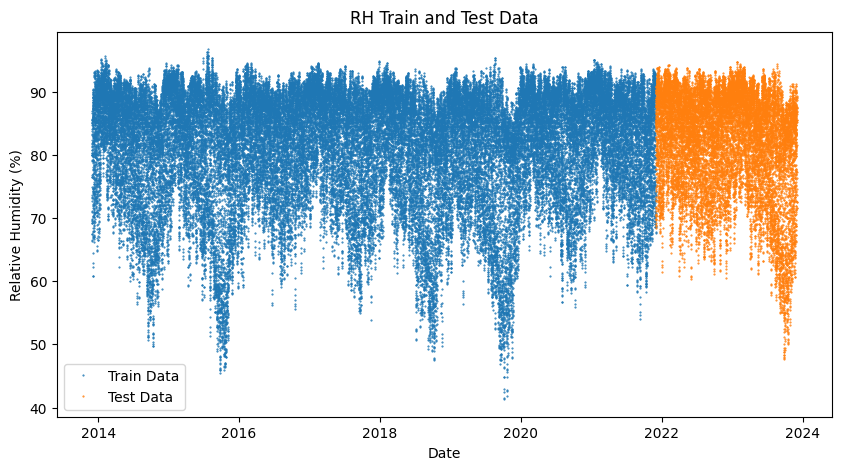

In [21]:
color_pal=sns.color_palette()
plt.figure(figsize=(10, 5))
plt.plot(train_data['y'].index, train_data['y'].values, '.', ms=1, color=color_pal[0], label='Train Data')
plt.plot(test_data['y'].index, test_data['y'].values, '.', ms=1, color=color_pal[1], label='Test Data')
plt.title('RH Train and Test Data')
plt.ylabel('Relative Humidity (%)')
plt.xlabel('Date')
plt.legend()
plt.show()

# traingin

In [22]:
from prophet import Prophet

def prophet_model(train_data, target_column, regressors):
    # parameter yang digunakan pada model Prophet
    params = {
        'growth': 'linear',
        'changepoints': None,
        'n_changepoints': 25,
        'changepoint_range': 0.8,
        'yearly_seasonality': 'auto',
        'weekly_seasonality': 'auto',
        'daily_seasonality': 'auto',
        'seasonality_mode': 'additive',
        'seasonality_prior_scale': 10.0,
        'holidays_prior_scale': 10.0,
        'changepoint_prior_scale': 0.05,
        'mcmc_samples': 0,
        'interval_width': 0.80,
        'uncertainty_samples': 1000,
        'stan_backend': None
    }
    
    model = Prophet(**params)
    
    # menambahkan regressor ke dalam model sebagai variabel eksogen
    for regressor in regressors:
        if regressor != target_column:
            model.add_regressor(regressor)
    
    df = train_data.copy()
    df['ds'] = df['ds']  # deret waktu
    df['y'] = df[target_column]  # variabel target
    
    # menambahkan regressor ke dalam DataFrame
    for regressor in regressors:
        if regressor != target_column:
            df[regressor] = train_data[regressor]
    
    fit_model = model.fit(df)
    
    return fit_model

target_column = 'y' 
regressors = ['t2m', 'ws10m', 'ps', 'y'] 

fit_model = prophet_model(train_data, target_column, regressors)

00:37:08 - cmdstanpy - INFO - Chain [1] start processing
00:38:33 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# params = {
#     'growth': 'linear',                     
#     'changepoints': None,                   
#     'n_changepoints': 25,                   
#     'changepoint_range': 0.8,               
#     'yearly_seasonality': 'auto',           
#     'weekly_seasonality': 'auto',           
#     'daily_seasonality': 'auto',            
#     'seasonality_mode': 'additive',         #
#     'seasonality_prior_scale': 10.0,        
#     'holidays_prior_scale': 10.0,           
#     'changepoint_prior_scale': 0.05,        
#     'mcmc_samples': 0,                      
#     'interval_width': 0.80,                 
#     'uncertainty_samples': 1000,            
#     'stan_backend': None                    
# }

# model = Prophet(**params)
# model.add_regressor('t2m')
# model.add_regressor('ws10m')
# model.add_regressor('ps')

# df['ds'] = df['ds']
# df['y'] = df['y']  
# df['t2m'] = df['t2m']
# df['ws10m'] = df['ws10m']
# df['ps'] = df['ps']


In [24]:
print(fit_model.params)

OrderedDict([('lp__', array([[201677.]])), ('k', array([[0.419973]])), ('m', array([[0.831507]])), ('delta', array([[-0.116288 , -1.4496   ,  1.8075   , -0.667788 , -0.631634 ,
         0.0326575,  2.45506  , -1.08682  , -1.69819  ,  1.38745  ,
        -1.05392  ,  0.512964 , -0.262124 ,  0.709978 , -0.34481  ,
         0.0100013, -1.79909  ,  2.79256  ,  0.0505008, -1.00308  ,
        -2.38075  ,  2.92158  ,  1.91934  , -3.40116  ,  0.84685  ]])), ('sigma_obs', array([[0.0338939]])), ('beta', array([[ 2.18819e-02,  1.99814e-03, -1.76913e-02, -1.10489e-03,
         3.31203e-03, -1.77735e-03, -1.21437e-04, -4.84033e-03,
         8.90801e-04,  1.89303e-03, -1.02241e-03, -6.08008e-05,
        -1.59885e-03, -9.57712e-08,  1.34264e-03,  1.83220e-04,
        -1.47721e-03,  4.71093e-04,  1.75474e-03, -1.09288e-03,
        -1.58655e-04,  1.18936e-04, -5.41678e-04,  2.03906e-04,
        -6.65673e-04, -1.93622e-05, -6.41817e-03,  1.88003e-02,
        -8.27006e-03, -6.80630e-03,  7.48127e-04, -3.

In [25]:
# fit_model = model.fit(train_data)

In [26]:
forecast = fit_model.predict(test_data)

In [27]:
f_train = fit_model.predict(train_data)

In [28]:
# f, ax = plt.subplots(1)
# f.set_figheight(5)
# f.set_figwidth(15)
# ax.scatter(test_data.index, test_data['y'], color='r')
# fig = model.plot(forecast, ax=ax)

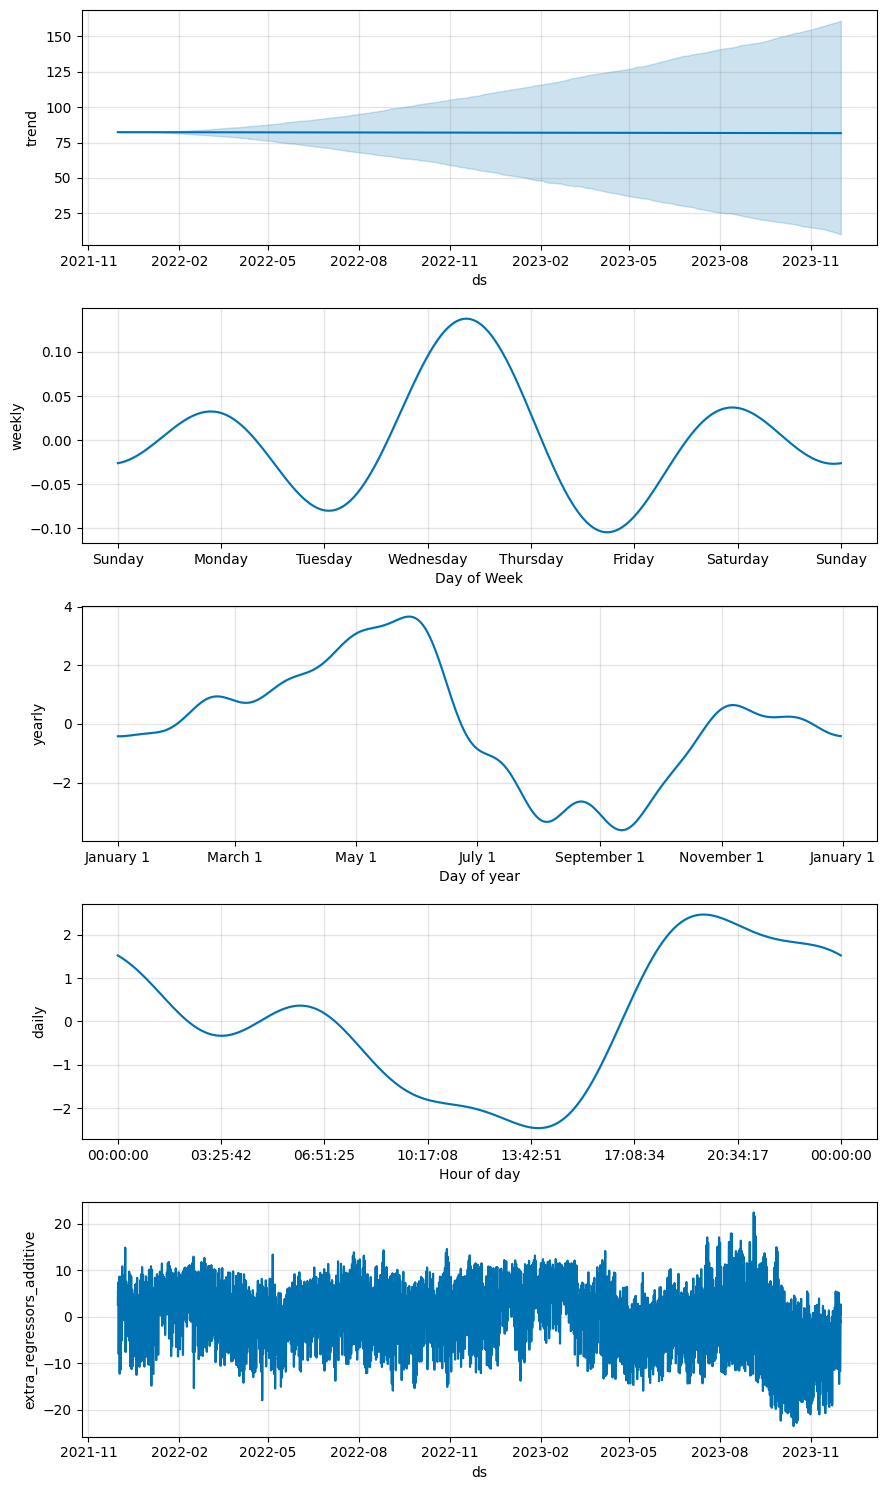

In [29]:
fig_comp = fit_model.plot_components(forecast)

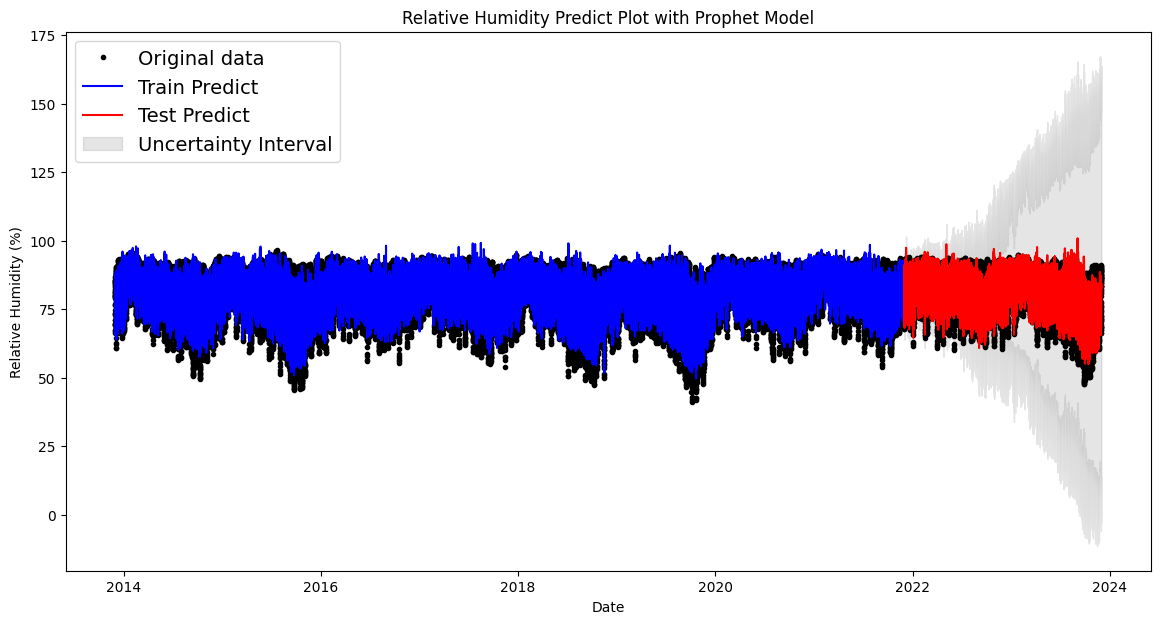

In [59]:
# Plot hasil prediksi
plt.figure(figsize=(14, 7))

# Plot data asli
plt.plot(df['ds'], df['y'], 'k.', label='Original data')

# Plot hasil prediksi train set
plt.plot(train_data['ds'], f_train['yhat'], 'b-', label='Train Predict')

# Plot hasil prediksi test set
plt.plot(test_data['ds'], forecast['yhat'], 'r-', label='Test Predict')

# Plot hasil prediksi test set
plt.fill_between(test_data['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Uncertainty Interval')

# Menampilkan error pada grafik
# plt.text(train_data['ds'].iloc[-1], f_train['yhat'].iloc[-1], f'Train MAE: {train_mae:.2f}', fontsize=12, color='blue')
# plt.text(test_data['ds'].iloc[0], forecast['yhat'].iloc[train_size], f'Test MAE: {test_mae:.2f}', fontsize=12, color='red')
# plt.text(0.5, 0.01, f'Train_MAE: {train_mae:.2f}, Test_MSE: {test_mae:.2f}, train_acc: {train_accuracy:.2f}, test_acc: {test_accuracy:.2f}',transform=ax.transAxes,
#          fontsize=12, verticalalignment='bottom', horizontalalignment='center',
#          bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.legend(loc=2, prop={'size':14})
plt.xlabel('Date')
plt.ylabel('Relative Humidity (%)')
plt.title('Relative Humidity Predict Plot with Prophet Model')
plt.show()


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Menghitung mean absolute error (MAE) pada train set dan test set
train_mae = mean_absolute_error(train_data['y'], f_train['yhat'])
test_mae = mean_absolute_error(test_data['y'], forecast['yhat'])

print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

from sklearn.metrics import accuracy_score
mean_value = df['y'].mean()
train_data['y_binary'] = (train_data['y'] > mean_value).astype(int)
test_data['y_binary'] = (test_data['y'] > mean_value).astype(int)
forecast['yhat_binary'] = (forecast['yhat'] > mean_value).astype(int)

# Mengambil prediksi biner untuk periode test set
forecast_test_binary = forecast['yhat_binary'].iloc[-len(test_data):].values
# Menghitung akurasi prediksi biner
accuracy = accuracy_score(test_data['y_binary'], forecast_test_binary)
print(f'Accuracy: {accuracy:.2f}')

f_train['yhat_binary'] = (f_train['yhat'] > mean_value).astype(int)
forecast['yhat_binary'] = (forecast['yhat'] > mean_value).astype(int)

# Mengambil prediksi biner untuk periode test set
forecast_test_binary = forecast['yhat_binary'].iloc[-len(test_data):].values

# Menghitung akurasi prediksi biner untuk data pelatihan
train_accuracy = accuracy_score(train_data['y_binary'], f_train['yhat_binary'])
print(f'Train Accuracy: {train_accuracy:.2f}')

# Menghitung akurasi prediksi biner untuk data pengujian
test_accuracy = accuracy_score(test_data['y_binary'], forecast_test_binary)
print(f'Test Accuracy: {test_accuracy:.2f}')

Train MAE: 2.5156991902769996
Test MAE: 2.6008748235297587
Accuracy: 0.89
Train Accuracy: 0.89
Test Accuracy: 0.89


In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

mae = mean_absolute_error(test_data['y'], forecast['yhat'])
mse = mean_squared_error(test_data['y'], forecast['yhat'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((np.array(test_data['y']) - np.array(forecast['yhat'])) / np.array(test_data['y']))) * 100
r2 = r2_score(test_data['y'], forecast['yhat'])

In [33]:
print('mae :', mae)
print('mse :', mse)
print('rmse :', rmse)
print('mape :', mape)
print('r2score:', r2)

mae : 2.6008748235297587
mse : 11.103142273943748
rmse : 3.332137793360855
mape : 3.247914270822231
r2score: 0.8255746145480971


In [34]:
# import joblib

# joblib.dump(fit_model, 'prophet_model_rh_new.pkl')

In [35]:
# model = joblib.load('prophet_model_rh_new.pkl')

In [36]:
# future_dates = pd.date_range(start='2024-06-01', end='2024-06-02', freq='h')
# future = pd.DataFrame(future_dates, columns=['ds'])

# # Add exogenous variables for future dates
# # You can use any method to fill in these future values, for simplicity, I'm just repeating the last available value
# future['t2m'] = df['t2m'].iloc[-1]
# future['ws10m'] = df['ws10m'].iloc[-1]
# future['ps'] = df['ps'].iloc[-1]

# # Predict with exogenous variables
# forecast = model.predict(future)

# # Plot the forecast
# fig = model.plot(forecast)

In [37]:
# # Define new data point for prediction, including all regressors used in training
# new_data_point = pd.DataFrame({
#     'ds': ['2024-06-13 11:00:00'], 
#     'y': [80], 
#     't2m': [30],
#     'ws10m': [2],
#     'ps': [100]
# })


# # Make prediction using the loaded model
# forecast = model.predict(new_data_point)

# # Display the prediction
# print(forecast[['ds', 'yhat']])

# Hyperparamter TUNING

In [38]:
# forecast

In [39]:
# import numpy as np
# # from fbprophet import Prophet
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from scipy.stats import uniform
# import random
# from itertools import product

# # Define your train_data and test_data here
# # global train_data, test_data

# def objective_function(args_list):
#     global train_data, test_data

#     params_evaluated = []
#     results = []

#     for idx, params in enumerate(args_list):
#         try:
#             model = Prophet(**params)
#             model.fit(train_data)
#             forecast = model.predict(test_data)
#             mae = mean_absolute_error(test_data['y'], forecast['yhat'])
#             mse = mean_squared_error(test_data['y'], forecast['yhat'])
#             rmse = np.sqrt(mse)
#             mape = np.mean(np.abs((np.array(test_data['y']) - np.array(forecast['yhat'])) / np.array(test_data['y']))) * 100
#             r2 = r2_score(test_data['y'], forecast['yhat'])

#             params_evaluated.append(params)
#             results.append(mse)  # Assuming you are optimizing for MSE, you can change this to any other metric
#         except Exception as e:
#             params_evaluated.append(params)
#             results.append(25.0)  # Giving high loss for exceptions regions of space
#             print(f"Exception raised for params {params}: {e}")

#         print(f"Iteration {idx + 1}/{len(args_list)}: Params: {params} => Result: {results[-1]}")

#     return params_evaluated, results

# param_space = dict(
#     growth=['linear', 'logistic', 'flat'],
#     n_changepoints=range(0, 55, 5),
#     yearly_seasonality=[True, False],
#     weekly_seasonality=[True, False],
#     daily_seasonality=[True, False],
#     seasonality_mode=['additive', 'multiplicative'],
#     uncertainty_samples=[500, 1000, 1500, 2000]
# )

# conf_Dict = dict()
# conf_Dict['num_iteration'] = 20

# # Create combinations of the discrete parameters
# discrete_param_combinations = list(product(
#     param_space['growth'],
#     param_space['n_changepoints'],
#     param_space['yearly_seasonality'],
#     param_space['weekly_seasonality'],
#     param_space['daily_seasonality'],
#     param_space['seasonality_mode'],
#     param_space['uncertainty_samples']
# ))

# # Adjust for other parameters that are generated from uniform distributions
# param_combinations = []
# for params in discrete_param_combinations:
#     params_dict = {
#         'growth': params[0],
#         'n_changepoints': params[1],
#         'yearly_seasonality': params[2],
#         'weekly_seasonality': params[3],
#         'daily_seasonality': params[4],
#         'seasonality_mode': params[5],
#         'uncertainty_samples': params[6],
#         'changepoint_range': uniform(0.5, 0.5).rvs(),
#         'seasonality_prior_scale': uniform(5.0, 15.0).rvs(),
#         'changepoint_prior_scale': uniform(0.0, 0.1).rvs(),
#         'interval_width': uniform(0.2, 0.8).rvs()
#     }
#     param_combinations.append(params_dict)

# # Select num_iteration parameter combinations randomly
# selected_combinations = random.sample(param_combinations, conf_Dict['num_iteration'])

# # Run the objective function for the selected parameter combinations
# params_evaluated, results = objective_function(selected_combinations)



In [40]:
# # Find the best parameters based on the results
# best_index = np.argmin(results)
# best_params = params_evaluated[best_index]
# best_result = results[best_index]

# print(f"Best Params: {best_params} => Best Result: {best_result}")

# # Retrain the model with the best parameters on the entire training dataset
# best_model = Prophet(**best_params)
# best_model.fit(train_data)

# # Make predictions on the test dataset
# forecast = best_model.predict(test_data)

# # Evaluate the model performance
# mae = mean_absolute_error(test_data['y'], forecast['yhat'])
# mse = mean_squared_error(test_data['y'], forecast['yhat'])
# rmse = np.sqrt(mse)
# mape = np.mean(np.abs((np.array(test_data['y']) - np.array(forecast['yhat'])) / np.array(test_data['y']))) * 100
# r2 = r2_score(test_data['y'], forecast['yhat'])

# print(f"Model Performance on Test Data:")
# print(f"MAE: {mae}")
# print(f"MSE: {mse}")
# print(f"RMSE: {rmse}")
# print(f"MAPE: {mape}%")
# print(f"R2 Score: {r2}")


In [41]:
# import numpy as np
# from prophet import Prophet
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from scipy.stats import uniform
# from scipy.optimize import fmin

# def objective_function(args_list):
#     global train_data, test_data

#     params_evaluated = []
#     results = []

#     for params in args_list:
#         try:
#             model = Prophet(**params)
#             model.fit(train_data)
#             forecast = model.predict(test_data)
#             mae = mean_absolute_error(test_data['y'], forecast['yhat'])
#             mse = mean_squared_error(test_data['y'], forecast['yhat'])
#             rmse = np.sqrt(mse)
#             mape = np.mean(np.abs((np.array(test_data['y']) - np.array(forecast['yhat'])) / np.array(test_data['y']))) * 100
#             r2 = r2_score(test_data['y'], forecast['yhat'])

#             params_evaluated.append(params)
#             results.append(mse)  # Assuming you are optimizing for MSE, you can change this to any other metric
#         except:
#             params_evaluated.append(params)
#             results.append(25.0)  # Giving high loss for exceptions regions of space

#     # Printing the evaluated parameters and their results
#     for param, result in zip(params_evaluated, results):
#         print(f"Params: {param} => Result: {result}")

#     return params_evaluated, results

# param_space = dict(
#     growth=['linear', 'logistic', 'flat'],
#     n_changepoints=range(0, 55, 5),
#     changepoint_range=uniform(0.5, 0.5),
#     yearly_seasonality=[True, False],
#     weekly_seasonality=[True, False],
#     daily_seasonality=[True, False],
#     seasonality_mode=['additive', 'multiplicative'],
#     seasonality_prior_scale=uniform(5.0, 15.0),
#     changepoint_prior_scale=uniform(0.0, 0.1),
#     interval_width=uniform(0.2, 0.8),
#     uncertainty_samples=[500, 1000, 1500, 2000]
# )

# conf_Dict = dict()
# conf_Dict['initial_random'] = 10
# conf_Dict['num_iteration'] = 50

In [42]:
# from itertools import product

# discrete_param_combinations = list(product(
#     param_space['growth'],
#     param_space['n_changepoints'],
#     param_space['yearly_seasonality'],
#     param_space['weekly_seasonality'],
#     param_space['daily_seasonality'],
#     param_space['seasonality_mode'],
#     param_space['uncertainty_samples']
# ))

# param_combinations = []
# for params in discrete_param_combinations:
#     params_dict = {
#         'growth': params[0],
#         'n_changepoints': params[1],
#         'yearly_seasonality': params[2],
#         'weekly_seasonality': params[3],
#         'daily_seasonality': params[4],
#         'seasonality_mode': params[5],
#         'uncertainty_samples': params[6],
#         'changepoint_range': uniform(0.5, 0.5).rvs(),
#         'seasonality_prior_scale': uniform(5.0, 15.0).rvs(),
#         'changepoint_prior_scale': uniform(0.0, 0.1).rvs(),
#         'interval_width': uniform(0.2, 0.8).rvs()
#     }
#     param_combinations.append(params_dict)

# # Run the objective function
# params_evaluated, results = objective_function(param_combinations)

# # Find the best parameters based on the results
# best_index = np.argmin(results)
# best_params = params_evaluated[best_index]
# best_result = results[best_index]

# print(f"Best Params: {best_params} => Best Result: {best_result}")

In [43]:
# from itertools import product

# param_combinations = list(product(
#     param_space['growth'],
#     param_space['n_changepoints'],
#     param_space['yearly_seasonality'],
#     param_space['weekly_seasonality'],
#     param_space['daily_seasonality'],
#     param_space['seasonality_mode'],
#     param_space['uncertainty_samples']
# ))

# # Adjust for other parameters that are generated from uniform distributions
# for params in param_combinations:
#     params_dict = {
#         'growth': params[0],
#         'n_changepoints': params[1],
#         'yearly_seasonality': params[2],
#         'weekly_seasonality': params[3],
#         'daily_seasonality': params[4],
#         'seasonality_mode': params[5],
#         'uncertainty_samples': params[6],
#         'changepoint_range': uniform(0.5, 0.5).rvs(),
#         'seasonality_prior_scale': uniform(5.0, 15.0).rvs(),
#         'changepoint_prior_scale': uniform(0.0, 0.1).rvs(),
#         'interval_width': uniform(0.2, 0.8).rvs()
#     }
#     param_combinations.append(params_dict)

# # Run the objective function
# params_evaluated, results = objective_function(params_combinations)

# # Find the best parameters based on the results
# best_index = np.argmin(results)
# best_params = params_evaluated[best_index]
# best_result = results[best_index]

# print(f"Best Params: {best_params} => Best Result: {best_result}")

In [44]:
# def objective_function(args_list):
#     global train_data, test_data

#     params_evaluated = []
#     results = []

#     for params in args_list:
#         try:
#             model = Prophet(**params)
#             model.fit(train_data)
#             forecast = model.predict(test_data)
#             mae = mean_absolute_error(test_data['y'], forecast['yhat'])
#             mse = mean_squared_error(test_data['y'], forecast['yhat'])
#             rmse = np.sqrt(mse)
#             mape = np.mean(np.abs((np.array(test_data['y']) - np.array(forecast['yhat'])) / np.array(test_data['y']))) * 100
#             r2 = r2_score(test_data['y'], forecast['yhat'])

#             params_evaluated.append(params)
#             results.append(error)
#         except:
#             #print(f"Exception raised for {params}")
#             #pass
#             params_evaluated.append(params)
#             results.append(25.0)# Giving high loss for exceptions regions of spaces

#         #print(params_evaluated, mse)
#     return params_evaluated, results

In [45]:
# from scipy.stats import uniform


# param_space = dict(growth = ['linear', 'logistic', 'flat'],
#                    n_changepoints  = range(0, 55, 5),
#                    changepoint_range  = uniform(0.5, 0.5),
#                    yearly_seasonality = [True, False],
#                    weekly_seasonality = [True, False],
#                    daily_seasonality = [True, False],
#                    seasonality_mode = ['additive', 'multiplicative'],
#                    seasonality_prior_scale=uniform(5.0, 15.0),
#                    changepoint_prior_scale=uniform(0.0, 0.1),
#                    interval_width = uniform(0.2, 0.8),
#                    uncertainty_samples = [500, 1000, 1500, 2000]
#                    )

In [46]:
# conf_Dict = dict()
# conf_Dict['initial_random'] = 10
# conf_Dict['num_iteration'] = 50

In [47]:
# df.sort_index(inplace=True)
# data_range = df.loc['2023-11-01 09:00:00':'2023-12-01 09:00:00']

In [48]:
# df['2021':'2022'].plot(subplots=True, figsize=(20,12))

In [49]:
# data_range['T2M'].plot()

In [50]:
# df.reset_index(inplace=True)

In [51]:
# def fit_prophet_model(params, data):
#     model = Prophet(
#         growth=params.get('growth', 'linear'),
#         n_changepoints=params.get('n_changepoints', 25),
#         changepoint_range=params.get('changepoint_range', 0.8),
#         yearly_seasonality=params.get('yearly_seasonality', True),
#         weekly_seasonality=params.get('weekly_seasonality', True),
#         daily_seasonality=params.get('daily_seasonality', True),  # For hourly data, daily seasonality is important
#         seasonality_mode=params.get('seasonality_mode', 'additive')
#     )
#     model.fit(data)
#     return model

# def make_predictions(model, periods, freq='H'):
#     future = model.make_future_dataframe(periods=periods, freq=freq)
#     forecast = model.predict(future)
#     return forecast

# def plot_results(model, forecast):
#     fig1 = model.plot(forecast)
#     plt.show()
#     fig2 = model.plot_components(forecast)
#     plt.show()
    
# def evaluate_model(model, data):
#     df_cv = cross_validation(model, initial='720 days', period='180 days', horizon='30 days')
#     df_performance = performance_metrics(df_cv)
#     return df_performance

# def grid_search(data):
#     param_grid = {
#         'growth': ['linear'], 
#         'changepoint_range': [0.8, 0.9],
#         'yearly_seasonality': [True, False],
#         'weekly_seasonality': [True, False],
#         'daily_seasonality': [True, False],
#         'seasonality_mode': ['additive', 'multiplicative']
#     }

#     best_params = None
#     best_score = float('inf')

#     for params in ParameterGrid(param_grid):
#         model = fit_prophet_model(params, data)
#         df_performance = evaluate_model(model, data)
#         score = df_performance['mape'].mean()  # Example scoring metric

#         if score < best_score:
#             best_score = score
#             best_params = params

#     return best_params, best_score



In [52]:
# if __name__ == "__main__":
#     # Load your dataset
    
#     # Split the dataset into training and testing sets


#     # Hyperparameter Tuning
#     best_params, best_score = grid_search(train_data.reset_index())
#     print(f'Best params: {best_params}')
#     print(f'Best score: {best_score}')

#     # Fit Model with Best Params
#     best_model = fit_prophet_model(best_params, train_data)

#     # Make Predictions
#     forecast = make_predictions(best_model, periods=len(test_data), freq='H')

#     # Plot Results
#     plot_results(best_model, forecast)
